# Variational Autoencoder
[Variational Autoencoder (VAE)](https://arxiv.org/pdf/1312.6114v10.pdf) is a generative model. Instead of using conventional variational inference, which bases on mean-field that assumes each variable of latent variables are mutually independent and approximate with only exponential distribution family, VAE employs neural network to approximate the intractable true posterior.

Unlike valina autoencoder, which just try to memorise and to be able to recover the inputs, VAE forces the latent variables observe a predefined distribution. Then we can generate something new with the generative model $p(z)p(x|z)$. 


## The model
An VAE can be seperated into two parts: inference model with parameters $\phi$ and generative model with parameters $\theta$. $x$ denotes the observed variables, i.e data, and $z$ denotes the latent variables. The *inference network* (encoder) map an input $x_i$ into an (approximate) posterior distribution over latent variables, and the *generative network*(decoder) can map any samples from the latent space back to the original sample space. According the Bayesian formula:
$$
p(z|x) = \frac{p(x|z)p(z)}{p(x)} = \frac{p(x|z)p(z)}{\int p(x|z)p(z) \,dz}.
$$

Because true posterior $p_{\theta}(z|x)$ is intractable, it is approximated with inference model $q_{\phi}(z|x)$. One thing to note is no assumptions are made to the true posterior, and neural networks are used for fitting in both inference and generative model. Presummably, the approximation $q_{\phi}(z|x)$ can capture complex distribution. 

The parameters of inference model $\phi$ and generative model $\theta$ is trained jointly. Let's see how it happen.
The goal is to approximate the true posterior $p_{\phi}(z|x)$ with $q_{\phi}(z|x)$, i.e. minimize 
$$D_{KL}( q_{\phi}(z|x) || p_{\theta}(z|x)).$$ 
Starting from the definition, we have:
\begin{equation} 
\begin{split}
D_{KL}(q_{\phi}(z|x)||p_{\theta}(z|x)) &= \int q_{\phi}(z|x) \log \frac{q_{\phi}(z|x)} {p_{\theta}(z|x)} \, dz\\
&= \int q_{\phi}(z|x) \log \frac{q_{\phi}(z|x) p(x)} {p_{\theta}(z,x)} \, dz\\
&= \int q_{\phi}(z|x) \log \frac{q_{\phi}(z|x)} {p_{\theta}(z,x)} \, dz + \int q_{\phi}(z|x) \log p(x) \, dz\\
&= \int q_{\phi}(z|x) \log \frac{q_{\phi}(z|x)} {p_{\theta}(z,x)} \, dz + \log p_{\theta}(x)\\
\end{split}
\end{equation}
So $$\log p_{\theta}(x) = D_{KL}( q_{\phi}(z|x) || p_{\theta}(z|x)) + \int q_{\phi}(z|x) \log \frac{p_{\theta}(z,x)}{q_{\phi}(z|x)}\, dz $$
and define the Evidence LOwer Bound(ELOB) $L = \int q_{\phi}(z|x) \log \frac{p_{\theta}(z,x)}{q_{\phi}(z|x)}\, dz$.

Since $\log p_{\theta}(x)$ is a constant w.r.t $z$, minimizing the $D_{KL}( q_{\phi}(z|x) || p_{\theta}(z|x))$ is maximizing the ELOB.

## Loss Function

Then our goal comes to maximizing the ELOB, which can be rewirted to:
\begin{equation} 
\begin{split}
L &= \int q_{\phi}(z|x) \log \frac{p_{\theta}(z,x)}{q_{\phi}(z|x)}\, dz\\
&= \int q_{\phi}(z|x) \log \frac{p_{\theta}(z) p_{\theta}(x|z)}{q_{\phi}(z|x)}\, dz\\
&= \int q_{\phi}(z|x) \log \frac{p_{\theta}(z)}{q_{\phi}(z|x)}\, dz + \int q_{\phi}(z|x) \log p_{\theta}(x|z) \, dz\\
&= -D_{KL}(q_{\phi}(z|x) || p_{\theta}(z)) + \int q_{\phi}(z|x) \log p_{\theta}(x|z) \, dz\\
\end{split}
\end{equation}

Usually, the first item $D_{KL}(q_{\phi}(z|x) || p_{\theta}(z))$ can be solved analytically, see below. The second item is the (negtive) reconstruction loss, i.e given x, we hope $p_{\theta}(z|x)$ can be close to 1, then $\log p_{\theta}(z|x)$ close to 0, which maximize the expectation.

## Reparameterizaton 
Two advantagens of reparameterization brings are: (1)it makes the model differentialble, thus can be optimized in SGD and backpropagation; (2) An estimator with lower variance bound. This [blog](http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/) gives a great and broard introduction of this trick.

[Kingma's slides](http://dpkingma.com/wordpress/wp-content/uploads/2015/12/talk_nips_workshop_2015.pdf) give a clear explaination. In the original form, back-propagation can not pass the random node $z$, which is the approximation of the true posterior $p(z|x)$. While after reparameterization, the random variable $z$ is in a deterministic form of another random variable $\epsilon$ with standard Gaussian distribution. Thus, $\epsilon$ can be regarded as input and BP can flow through the computation graph.

Kingma also points out that when the mini-batch size is great enough, say 100, the sample size of the MCMC estimator can be just set to 1. This is important when implementing the model.

![reparameterizaiton](images/repa_trick.png)

## Solve KL analatically
Let prior $p_{\theta}(z) \sim N(0, I)$, where $z$ is the latent (unobserved) variable, the approximate posterior $q_{\phi}(z|x) \sim \mathbf{N}(\mathbf{\mu}, \sigma^{2}\mathbf{I})$.

Then we solve the KL divergence $\mathbf{D}_{KL}( q_{\phi}(z|x) || p_{\theta}(z))$.

\begin{equation} 
\begin{split}
\mathbf{D}_{KL}( q_{\phi}(z|x) || p_{\theta}(z)) 
&= \int q_{\phi}(z|x) \log \frac{q_{\phi}(z|x)}{p_{\theta}(z)} \, dz \\
&= \int q_{\phi}(z|x) (\log \prod_{i} \frac{1}{\sqrt{2 \pi \sigma_{i}^{2}}}\exp {-\frac{(z_i -\mu_i)^2}{2\sigma_{i}^{2}}} - \log \prod_{i} \frac{1}{\sqrt{2 \pi}}\exp {-\frac{z_i^2}{2}}) \, dz \\
&= \int q_{\phi}(z|x) \sum_{i} (-\frac{1}{2} \log 2 \pi \sigma_{i}^{2} -\frac{(z_i -\mu_i)^2}{2\sigma_{i}^{2}} +\frac{1}{2} \log 2 \pi + \frac{z_i^2}{2}) \, dz\\
&= -\frac{1}{2} \int q_{\phi}(z|x) \sum_{i} ( \log 2 \pi \sigma_{i}^{2} + \frac{(z_i -\mu_i)^2}{\sigma_{i}^{2}} -\log 2 \pi - z_{i}^{2}) \, dz\\
&= -\frac{1}{2} (\int q_{\phi}(z|x) \sum_{i} (\log \sigma_{i}^{2} + \frac{(z_i -\mu_i)^2}{\sigma_{i}^{2}}) \, dz -\int q_{\phi}(z|x) \sum_{i} z_{i}^{2}\, dz)\\
&= -\frac{1}{2} \sum_{i} (\log \sigma_{i}^{2} + 1) + \frac{1}{2} \int q_{\phi}(z|x) \sum_{i}\big[(z_i-\mu_i)^2 + 2\mu_i (z_i -\mu_i) +\mu_{i}^{2} \big] \, dz\\
&= -\frac{1}{2} \sum_{i} (\log \sigma_{i}^{2} + 1) + \frac{1}{2} \sum_{i}\big[\sigma_{i}^2 +\mu_{i}^{2} \big]\\
&= -\frac{1}{2} \sum_{i} (\log \sigma_{i}^{2} + 1 - \sigma_{i}^2 - \mu_{i}^{2}) 
\end{split}
\end{equation}

## Implementation with Tensorflow

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz
Total samples: 55000, batches: 550
Training starts ...
Epoch  0 , loss: 198.1166
Epoch  5 , loss: 119.5847
Epoch 10 , loss: 108.4700
Epoch 15 , loss: 103.8259
Epoch 20 , loss: 106.6798
Epoch 25 , loss: 101.6897
Epoch 30 , loss: 103.4965
Epoch 35 , loss: 102.2417
Epoch 40 , loss: 101.6179
Epoch 45 , loss: 104.6986
Epoch 50 , loss: 104.0825
Epoch 55 , loss: 100.6868
Epoch 60 , loss: 102.2277
Epoch 65 , loss: 98.2457


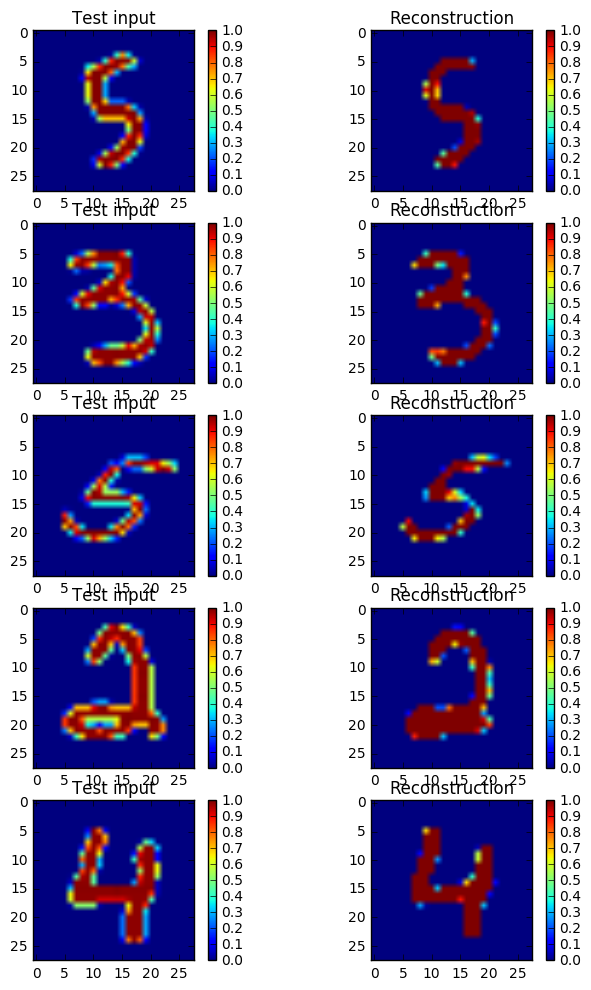

In [5]:
from __future__ import division

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt

"""
This is a VAE implementation on MNIST dataset.
"""

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.001)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.0, shape=shape) # should be a float
    return tf.Variable(initial)

# define a dense (fully-connected) linear layer
def linear(shape):
    '''
    return a function takes the placeholder x as input 
    '''
    def transform(x):
        W = weight_variable(shape)
        b = bias_variable([shape[1]])
        return tf.matmul(x, W) + b
    return transform


def encoder(x):
    # Hidden layer encoder
    enc_l1 = linear([input_dim, hidden_encoder_dim])
    # Mu and Sigma encoder
    enc_mu = linear([hidden_encoder_dim, latent_dim])
    enc_logvar_sigma = linear([hidden_encoder_dim, latent_dim])

    hidden_output = tf.nn.relu(enc_l1(x))
    return enc_mu(hidden_output), enc_logvar_sigma(hidden_output), hidden_output


def decoder(z):
    # Hidden layer decoder
    dec_l1 = linear([latent_dim, hidden_decoder_dim])
    hidden_output = tf.nn.relu(dec_l1(z))
    return hidden_output


def sampling(enc_mu, enc_logvar_sigma):
    epsilon = tf.random_normal(tf.shape(enc_logvar_sigma), name='epsilon')
    enc_std = tf.exp(0.5 * enc_logvar_sigma)
    z = enc_mu + enc_std * epsilon
    return z


def loss_function(enc_mu, enc_logvar_sigma, x, hidden_output):
    # force the distribution of latent variables close to prior z
    KLD = -0.5 * tf.reduce_sum(1 + enc_logvar_sigma -tf.pow(enc_mu, 2) - tf.exp(enc_logvar_sigma), 1)
    # recover the x 
    reconstruction_l = linear([hidden_decoder_dim, input_dim])
    x_hat = reconstruction_l(hidden_output)
    # calculate the reconstruction loss
    recon_error = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(x_hat, x), 1)
    
    # the total loss
    loss = tf.reduce_mean(KLD + recon_error)
    return loss, x_hat


if __name__ == "__main__":
    mnist = input_data.read_data_sets('MNIST')

    input_dim = 784
    hidden_encoder_dim = 400
    hidden_decoder_dim = 400
    latent_dim = 20

    batch_size = 100

    # placeholder for batch data, None means any dimension
    x = tf.placeholder("float", shape=[None, input_dim])
    enc_mu, enc_logvar_sigma, hidden_enc_output = encoder(x)

    z = sampling(enc_mu, enc_logvar_sigma)
    hidden_output = decoder(z)
    loss, x_hat = loss_function(enc_mu, enc_logvar_sigma, x, hidden_output)

    optimizer_step = tf.train.AdamOptimizer(0.001).minimize(loss)

    n_samples = mnist.train.num_examples
    n_batches = n_samples // batch_size
    print "Total samples: %d, batches: %d" % (n_samples, n_batches)
    
    print "Training starts ..."
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        n_epochs = 70 
        for ind in xrange(n_epochs):
            loss_list = []
            for step in range(n_batches):
                batch = mnist.train.next_batch(batch_size)  # batch = (x, y)
                _, current_loss = sess.run([optimizer_step, loss], feed_dict={x: batch[0]})
                loss_list.append(current_loss)
                
            if ind % 5 == 0:
                print "Epoch %2d , loss: %.4f" % (ind, current_loss)
                
        # Test: visualization
        batch = mnist.train.next_batch(5000)
        x_ori = batch[0]
        y = batch[1]
        z, x_new = sess.run([z, x_hat], feed_dict={x: x_ori})

        plt.figure(figsize=(8, 12))
        for i in range(5):

            plt.subplot(5, 2, 2*i + 1)
            plt.imshow(x_ori[i].reshape(28, 28), vmin=0, vmax=1)
            plt.title("Test input")
            plt.colorbar()
            plt.subplot(5, 2, 2*i + 2)
            plt.imshow(x_new[i].reshape(28, 28), vmin=0, vmax=1)
            plt.title("Reconstruction")
            plt.colorbar()
        plt.show()


Then we set the dimension of the latent space to 2 and visualize the latent variables.

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz
Total samples: 55000, batches: 550
Training starts ...
Epoch  0 , loss: 196.6966
Epoch  5 , loss: 167.0963
Epoch 10 , loss: 160.6466
Epoch 15 , loss: 159.2789
Epoch 20 , loss: 151.1659
Epoch 25 , loss: 148.5882
Epoch 30 , loss: 155.2178
Epoch 35 , loss: 144.0406


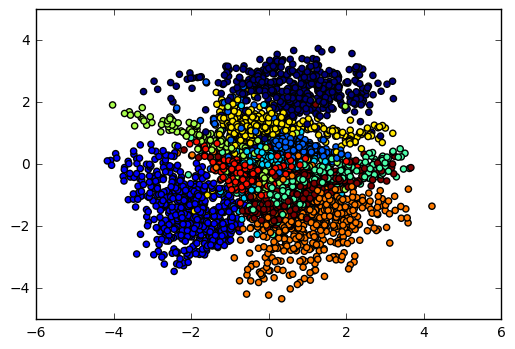

In [6]:
if __name__ == "__main__":
    mnist = input_data.read_data_sets('MNIST')

    input_dim = 784
    hidden_encoder_dim = 400
    hidden_decoder_dim = 400
    latent_dim = 2

    batch_size = 100

    # placeholder for batch data, None means any dimension
    x = tf.placeholder("float", shape=[None, input_dim])
    enc_mu, enc_logvar_sigma, hidden_enc_output = encoder(x)

    z = sampling(enc_mu, enc_logvar_sigma)
    hidden_output = decoder(z)
    loss, x_hat = loss_function(enc_mu, enc_logvar_sigma, x, hidden_output)

    optimizer_step = tf.train.AdamOptimizer(0.001).minimize(loss)

    n_samples = mnist.train.num_examples
    n_batches = n_samples // batch_size
    print "Total samples: %d, batches: %d" % (n_samples, n_batches)
    
    print "Training starts ..."
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        n_epochs = 40 
        for ind in xrange(n_epochs):
            loss_list = []
            for step in range(n_batches):
                batch = mnist.train.next_batch(batch_size)  # batch = (x, y)
                _, current_loss = sess.run([optimizer_step, loss], feed_dict={x: batch[0]})
                loss_list.append(current_loss)
                
            if ind % 5 == 0:
                print "Epoch %2d , loss: %.4f" % (ind, current_loss)
                
        # Test: visualization
        batch = mnist.train.next_batch(5000)
        x_ori = batch[0]
        y = batch[1]
        z, x_new, means = sess.run([z, x_hat, enc_mu], feed_dict={x: x_ori})

        plt.scatter(means[:, 0], means[:, 1], c=y)
        #plt.colorbar()
        plt.show()
